<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/kl.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(kl_notebook)=
# Kullback-Leibler

Nel contesto di molti ambiti della statistica e del machine learning, non è raro trovare la necessità di utilizzare una distribuzione di probabilità $ q $ per approssimare un'altra distribuzione $ p $. Questo può essere particolarmente utile quando la distribuzione $ p $ è sconosciuta o troppo complessa per essere trattata direttamente. Di conseguenza, emerge una questione cruciale: quanta informazione viene perduta utilizzando $ q $ al posto di $ p $? Qual è l'incremento di incertezza introdotto nell'analisi statistica a causa di questa approssimazione?

Per rispondere a questa domanda, una misura chiave è la *Divergenza di Kullback-Leibler* (KL). La Divergenza KL, denotata come $ \mathbb{KL}(p \mid\mid q) $, rappresenta la discrepanza tra le due distribuzioni di probabilità. Essa assume il valore di zero quando $ q $ è identica a $ p $ e aumenta con la differenza tra le due distribuzioni. Pertanto, la Divergenza KL funge da criterio per valutare la 'vicinanza' tra due distribuzioni di probabilità.

Oltre alla Divergenza KL, un altro concetto rilevante in questo contesto è l'*Expected Log Predictive Density* (elpd). L'elpd è una misura di quanto bene un modello si adatta ai dati osservati e può essere utilizzata per confrontare diversi modelli, fornendo un equilibrio tra adattamento e complessità del modello.

Questo capitolo mira ad introdurre ed esplorare in profondità sia la Divergenza KL che l'elpd, evidenziando la loro centralità nella valutazione e nel confronto dei modelli statistici, in particolare nel contesto bayesiano. Attraverso una comprensione dettagliata di questi concetti, il lettore sarà in grado di applicare queste metriche in modo efficace nella selezione e nell'analisi di modelli appropriati per specifici set di dati.

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [4]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Perdita di informazione e divergenza di Kullback-Leibler

Per quantificare la perdita di informazione che si verifica quando utilizziamo una distribuzione di probabilità approssimata $ q $ al posto della distribuzione corretta $ p $, abbiamo bisogno di una misura che sia zero quando $ q = p $, e positiva quando $ q \neq p $. 

Una tale misura è fornita dalla *divergenza di Kullback-Leibler* (o *entropia relativa*), che è definita come il valore atteso della differenza tra $ \log(p) $ e $ \log(q) $, calcolato rispetto alla distribuzione $ p $. In formula:

$$
\begin{equation}
\mathbb{KL} (p \mid\mid q) = \mathbb{E}_p [\log p - \log q] = \sum_i^n p_i (\log p_i - \log q_i),
\end{equation}
$$

dove $ \mathbb{KL} (p \mid\mid q) $ quantifica la differenza media nelle probabilità logaritmiche quando utilizziamo $ q $ per approssimare $ p $. 

È importante notare che la divergenza di Kullback-Leibler non è simmetrica: $ \mathbb{KL} (p \mid\mid q) \neq \mathbb{KL} (q \mid\mid p) $.

### Relazione con l'entropia

La divergenza di Kullback-Leibler può essere riscritta in termini dell'entropia $ h(p) $ di $ p $ e dell'entropia incrociata $ h(p, q) $ tra $ p $ e $ q $, come segue:

$$
\begin{equation}
\mathbb{KL} (p \mid\mid q) = h(p, q) - h(p),
\end{equation}
$$

dove

$$
\begin{align*}
h(p) & = -\sum_i^n p_i \log p_i, \\
h(p, q) & = -\sum_i^n p_i \log q_i.
\end{align*}
$$

In questa espressione, $ h(p) $ è l'entropia di $ p $, che misura l'incertezza media associata agli eventi secondo la distribuzione $ p $. $ h(p, q) $ è l'entropia incrociata tra $ p $ e $ q $, che rappresenta l'incertezza media quando si usano le log-probabilità di $ q $, ma ponderate con le probabilità di $ p $.

Per chiarire: l'entropia $h(p)$ di una distribuzione $p$ è una misura dell'incertezza intrinseca in quella distribuzione. L'entropia incrociata $h(p, q)$ tra due distribuzioni $p$ e $q$ misura l'incertezza media quando si usano le log-probabilità di $q$, ma ponderate con le probabilità di $p$. Essa rappresenta la quantità di informazione media necessaria per codificare gli eventi di $p$ usando il codice ottimale per $q$.

La divergenza di Kullback-Leibler (KL) tra $p$ e $q$ è una misura della differenza tra queste due distribuzioni. Non è simmetrica e può essere vista come la quantità di informazione "persa" quando si usa $q$ per approssimare $p$.

### Interpretazione

La divergenza di Kullback-Leibler può essere interpretata come la differenza tra l'entropia incrociata $ h(p, q) $ e l'entropia $ h(p) $. In altre parole, rappresenta quanto l'entropia (o incertezza) aumenta quando utilizziamo la distribuzione $ q $ per approssimare la distribuzione $ p $ invece di utilizzare $ p $ stessa.

Se $ \mathbb{KL} (p \mid\mid q) = 0 $, questo indica che le due distribuzioni sono identiche e non c'è perdita di informazione nell'utilizzare $ q $ al posto di $ p $. Se $ \mathbb{KL} (p \mid\mid q) $ è positiva, indica la quantità di informazione che viene persa quando $ q $ viene utilizzata per rappresentare $ p $.

### Un esempio empirico

Ora vediamo un esempio numerico in Python per illustrare meglio questi concetti:

In [11]:
# Definiamo due distribuzioni di probabilità discreta p e q
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.6, 0.3])

# Calcoliamo l'entropia di p
h_p = -np.sum(p * np.log2(p))

# Calcoliamo l'entropia incrociata tra p e q
h_pq = -np.sum(p * np.log2(q))

# Calcoliamo la divergenza di Kullback-Leibler da p a q
kl_pq = h_pq - h_p

# Stampiamo i risultati
print("Entropia di p: ", h_p)
print("Entropia incrociata tra p e q: ", h_pq)
print("Divergenza KL da p a q: ", kl_pq)

Entropia di p:  1.4854752972273344
Entropia incrociata tra p e q:  1.5539580943104374
Divergenza KL da p a q:  0.06848279708310301


Consideriamo un secondo esempio. Sia $p$ una distribuzione binomiale di parametri $\theta = 0.2$ e $n = 5$

In [12]:
# Define the parameters
n = 4
p = 0.2

# Compute the probability mass function
true_py = stats.binom.pmf(range(n + 1), n, p)
print(true_py)

[0.4096 0.4096 0.1536 0.0256 0.0016]


Sia $q_1$ una approssimazione a $p$:

In [13]:
q1 = np.array([0.46, 0.42, 0.10, 0.01, 0.01])
print(q1)

[0.46 0.42 0.1  0.01 0.01]


Sia $q_2$ una distribuzione uniforme:

In [14]:
q2 = [0.2] * 5
print(q2)

[0.2, 0.2, 0.2, 0.2, 0.2]


La divergenza $\mathbb{KL}$ di $q_1$ da $p$ è

In [15]:
np.sum(true_py * np.log(true_py / q1))

0.029251990333458988

La divergenza $\mathbb{KL}$ di $q_2$ da $p$ è:

In [16]:
np.sum(true_py * np.log(true_py / q2))

0.4863577787141544

È chiaro che perdiamo una quantità maggiore di informazioni se, per descrivere la distribuzione binomiale $p$, usiamo la distribuzione uniforme $q_2$ anziché $q_1$.

### La divergenza dipende dalla direzione

La divergenza $\mathbb{KL}$ non è una vera e propria metrica: per esempio, non è simmetrica. In generale, $\mathbb{KL}(p \mid\mid q) \neq \mathbb{KL}(q \mid\mid p)$, ovvero la $\mathbb{KL}$ da $p$ a $q$ è diversa dalla $\mathbb{KL}$ da $q$ a $p$.

Consideriamo il seguente esempio:

In [19]:
# Create a DataFrame
data = {"direction": ["Da q a p", "Da p a q"], "p_1": [0.01, 0.7], "q_1": [0.7, 0.01]}

# Initialize the DataFrame
df = pd.DataFrame(data)

# Compute KL
df["p_2"] = 1 - df["p_1"]
df["q_2"] = 1 - df["q_1"]
df["d_kl"] = (df["p_1"] * (df["p_1"] / df["q_1"]).apply(np.log)) + (
    df["p_2"] * (df["p_2"] / df["q_2"]).apply(np.log)
)
print(df)

  direction   p_1   q_1   p_2   q_2      d_kl
0  Da q a p  0.01  0.70  0.99  0.30  1.139498
1  Da p a q  0.70  0.01  0.30  0.99  2.615770


## Confronto tra modelli

La divergenza $\mathbb{KL}$ viene utilizzata nel confronto tra modelli, ovvero ci consente di quantificare l'informazione che viene perduta quando utilizziamo la distribuzione di probabilità ipotizzata da un modello, chiamiamola $p_{\mathcal{M}}$, per approssimare la distribuzione di probabilità del vero modello generatore dei dati, $p_t$.

In precedenza abbiamo introdotto il concetto di distribuzione predittiva a posteriori:

$$
p(\tilde{y} \mid y) = \int_\Theta p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname {d}\!\theta .
$$

La distribuzione predittiva a posteriori descrive il tipo di dati che ci aspettiamo vengano prodotti dal modello generativo $\mathcal{M}$, alla luce delle nostre credenze iniziali, $p(\theta)$, e dei dati osservati, $y$. Quando valutiamo un modello ci chiediamo in che misura $p_{\mathcal{M}}(\tilde{y} \mid y)$ approssimi $p_t(\tilde{y})$. Cioè, ci chiediamo quanto siano simili i dati $p_{\mathcal{M}}(\cdot)$ prodotti dal modello $\mathcal{M}$ ai dati prodotti dal vero processo generatore dei dati $p_t(\cdot)$.

Una misura della "somiglianza" tra la distribuzione $q_{\mathcal{M}}$ ipotizzata dal modello $\mathcal{M}$ e la distribuzione $p_t$ del vero modello generatore dei dati è appunto fornita dalla divergenza di Kullback-Leibler $\mathbb{KL}(p_t \mid\mid q_{\mathcal{M}})$. 

Supponendo di avere $k$ modelli della distribuzione a posteriori, $\{q_{\mathcal{M}_1}, q_{\mathcal{M}_2}, \dots, q_{\mathcal{M}_k}\}$, e di conoscere il vero modello generatore dei dati, possiamo scrivere

$$
\begin{align}
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_1}) &= \mathbb{E} (\log p_{\mathcal{M}_0}) - \mathbb{E} (\log q_{\mathcal{M}_1})\notag\\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_2}) &= \mathbb{E} (\log p_{\mathcal{M}_0}) - \mathbb{E} (\log q_{\mathcal{M}_2})\notag\\
&\cdots\notag\\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_k}) &= \mathbb{E} (\log p_{\mathcal{M}_0}) - \mathbb{E} (\log q_{\mathcal{M}_k}).
\end{align}
$$ (eq-kl-mod-comp)

La {eq}`eq-kl-mod-comp` può sembrare un esercizio futile poiché nella vita reale non conosciamo il vero modello generatore dei dati. È però facile rendersi conto che, poiché $p_t$ è la stessa per tutti i confronti, diventa possibile costruire un ordinamento dei modelli basato unicamente sul secondo termine della {eq}`eq-kl-mod-comp`, ovvero senza nessun riferimento al vero modello generatore dei dati. Per un generico modello $\mathcal{M}$, il secondo termine della {eq}`eq-kl-mod-comp` può essere scritto come:

$$
\begin{equation}
\mathbb{E} \log p_{\mathcal{M}}(y) = \int_{-\infty}^{+\infty}p_{t}(y)\log p_{\mathcal{M}}(y) \,\operatorname {d}\!y .
\end{equation} 
$$ (eq-kl-div-cont-t2)

## Expected log predictive density

Le previsioni del modello $\mathcal{M}$ sui nuovi dati futuri sono date dalla distribuzione predittiva a posteriori. Possiamo dunque riscrivere la {eq}`eq-kl-div-cont-t2` come

$$
\begin{equation}
elpd = \int_{\tilde{y}} p_{t}(\tilde{y}) \log p(\tilde{y} \mid y) \,\operatorname {d}\!\tilde{y}.
\end{equation}
$$ (eq-elpd)

L'eq. {eq}`eq-elpd` è chiamata *expected log predictive density* ($elpd$) e fornisce la risposta al problema che ci eravamo posti: nel confronto tra modelli, come è possibile scegliere il modello più simile al vero meccanismo generatore dei dati? Possiamo pensare alla {eq}`eq:elpd` dicendo che descrive la distribuzione predittiva a posteriori del modello ponderando la verosimiglianza dei possibili (sconosciuti) dati futuri ($\tilde{y}$) con la vera distribuzione $p_t$. Di conseguenza, valori $elpd$ più grandi identificano il modello che risulta più simile al vero meccanismo generatore dei dati.

Non dobbiamo preoccuparci di trovare una formulazione analitica della distribuzione predittiva a posteriori $p(\tilde{y} \mid y)$ perché è possibile approssimare tale distribuzione mediante simulazione. Notiamo però che la {eq}`eq:elpd` include un termine, $p_t(\tilde{y})$, il quale descrive la distribuzione dei dati futuri $\tilde{y}$ secondo il vero modello generatore dei dati. Il termine $p_t$, ovviamente, è ignoto. Di conseguenza, la quantità $elpd$ non può mai essere calcolata in maniera esatta, ma può solo essere stimata. Il secondo problema di questo capitolo è capire come la {eq}`eq-elpd` possa essere stimata utilizzando un campione di osservazioni.

### Un esempio pratico

Esaminiamo un esempio tratto da [Bayesian Data Analysis for Cognitive Science](https://vasishth.github.io/bayescogsci/book/expected-log-predictive-density-of-a-model.html) nel quale la $lppd$ viene calcolata in forma esatta oppure mediante approssimazione. Supponiamo di disporre di un campione di $n$ osservazioni. Supponiamo inoltre di conoscere il vero processo generativo dei dati (qualcosa che in pratica non è mai possibile), ovvero:

$$
p_t(y) = Beta(1, 3).
$$ 

I dati sono

In [14]:
np.random.seed(75)

# Number of samples
n = 10000

# Draw samples from a Beta distribution
y_data = np.random.beta(1, 3, n)

# Print the first 6 elements of the array, equivalent to R's head function
print(y_data[:6])

[0.21810354 0.05532253 0.13545025 0.42102514 0.14728608 0.11052926]



Supponiamo inoltre di avere adattato ai dati un modello bayesiano $\mathcal{M}$ e di avere ottenuto la distribuzione a posteriori per i parametri del modello. Inoltre, supponiamo di avere derivato la forma analitica della distribuzione predittiva a posteriori per il modello:

$$
p(y^{rep} \mid y) \sim Beta(2, 2).
$$

Questa distribuzione ci dice quanto sono credibili i possibili dati futuri.

Conoscendo la vera distribuzione dei dati $p_t(y)$ possiamo calcolare in forma esatta la quantità $elpd$, ovvero

$$
elpd = \int_{y^{rep}}p_{t}(y^{rep})\log p(y^{rep} \mid y) \,\operatorname {d}\!y^{rep}.
$$

Svolgiamo i calcoli otteniamo:

In [15]:
from scipy.stats import beta
from scipy.integrate import quad

# True distribution
def p_t(y):
    return beta.pdf(y, 1, 3)

# Predictive distribution
def p(y):
    return beta.pdf(y, 2, 2)

# Integration
def integrand(y):
    return p_t(y) * np.log(p(y))

# Perform numerical integration
result, error = quad(integrand, 0, 1)

print(result)
print(error)

-0.3749071974384449
3.0236368964153826e-12


Tuttavia, in pratica non conosciamo mai $p_t(y)$. Quindi approssimiamo $elpd$ usando la {eq}`eq-elpd`:

$$
\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid y).
$$

Così facendo otteniamo un valore approssimato a quello trovato in precedenza:

In [16]:
1/n * np.sum(np.log(p(y_data)))

-0.3721938430299501

## Validazione incrociata Leave One Out (LOO)

Abbiamo visto che l'ELPD (Expected Log Predictive Density) è la densità logaritmica predittiva prevista per un nuovo punto dati. Questa misura indica quanto bene un modello statistico riesce a prevedere nuovi dati non ancora osservati. Un valore di ELPD più elevato suggerisce che le previsioni del modello sono maggiormente in accordo con la realtà del nuovo punto dati.

Ma come si può ottenere il valore dell'ELPD? Se si ricorre a un metodo di stima MCMC (Catena di Markov Monte Carlo), l'ELPD può essere approssimato mediante la *Leave One Out Cross-Validation* (LOO-CV). Con il metodo LOO, si rimuove un'osservazione dal campione, si adatta il modello ai dati rimanenti, e si verifica quanto bene esso predice l'osservazione esclusa. Si ripete questo processo per ogni osservazione nel set di dati, una per volta, e infine si calcola la media dei risultati per ottenere una stima LOO. La libreria PyMC automatizza questo procedimento.

### Pareto k diagnostic values

I valori diagnostici Pareto $ k $ sono utilizzati nell'ambito della validazione incrociata Leave-One-Out (LOO) per valutare l'accuratezza dell'approssimazione LOO. Il valore di $ k $ è un indicatore della qualità dell'approssimazione e può essere interpretato come segue:

- **$ k < 0.5 $**: L'approssimazione è generalmente considerata eccellente. L'errore nell'approssimazione è trascurabile.
- **$ 0.5 \leq k < 0.7 $**: L'approssimazione è ancora buona, ma con qualche preoccupazione. Potrebbe essere utile ispezionare il modello e i dati più attentamente.
- **$ 0.7 \leq k < 1 $**: L'approssimazione è mediocre. I risultati LOO possono essere inaffidabili, e potrebbe essere necessario utilizzare altre tecniche di validazione incrociata o rivedere il modello.
- **$ k \geq 1 $**: L'approssimazione è cattiva, e i risultati LOO sono molto probabilmente inaffidabili. Questo può indicare un problema serio con il modello o con il metodo di approssimazione utilizzato.

I valori diagnostici Pareto $ k $ si basano sulla distribuzione di Pareto e misurano quanto le code della distribuzione delle differenze di log-likelihood (differenze tra il log-likelihood per l'osservazione lasciata fuori e il log-likelihood per l'intero dataset) si discostano da una distribuzione esponenziale. Valori elevati di $ k $ indicano che le code sono più pesanti del previsto, suggerendo che l'approssimazione LOO potrebbe non essere accurata.

Questi valori forniscono un mezzo pratico per valutare l'affidabilità dell'approssimazione LOO, permettendo ai ricercatori di identificare potenziali problemi con il modello o con la tecnica di validazione incrociata utilizzata.

### L'utilizzo dell'ELPD nel confronto dei modelli

Una stima dell'ELPD, ottenuta ad esempio tramite LOO, è utile per confrontare modelli diversi, fornendo una misura oggettiva per stabilire quale modello si adatti meglio ai dati osservati. Questo criterio diventa particolarmente prezioso quando c'è la necessità di scegliere il modello più appropriato tra diverse opzioni, o di valutare se un modello più complesso offra un adattamento migliore rispetto a uno più semplice.

In sintesi, l'ELPD è un indicatore fondamentale per valutare la capacità predittiva di un modello, mentre la LOO è una tecnica che consente di approssimarlo. Utilizzando metodi come la LOO, gli analisti possono ottenere una valutazione precisa e robusta dei vari modelli, facilitando così la scelta del modello più adatto al contesto specifico. L'automazione di questo processo attraverso librerie come PyMC rende l'approccio ancora più accessibile e praticabile.

### Simulazione

Per illustrare questa procedura, eseguiamo una simulazione. Generiamo dei dati sintetici nei quali esiste una relazione lineare tra x e y. In questo contesto, potremmo voler confrontare un modello lineare con un modello più semplice, che include solo l'intercetta, ad esempio, e utilizzare la procedura LOO-CV per determinare quale modello si adatta meglio ai dati. La stima dell'elpd fornirà un criterio quantitativo per questo confronto, guidando la selezione del modello.

In [6]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

Adattiamo ai dati un modello che rispecchia il vero meccanismo generativo dei dati.

Si noti che, per calcolare LOO e WAIC, ArviZ ha bisogno di accedere alla log-likelihood per ogni campione posteriore. Possiamo trovarla tramite `compute_log_likelihood()`. In alternativa, possiamo passare `idata_kwargs={"log_likelihood": True}` a `sample()` per farla calcolare automaticamente alla fine del campionamento.

In [7]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    linear_trace = pm.sample(1000, tune=1000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Adattiamo ora un secondo modello che non tiene conto della relazione lineare tra x e y.

In [8]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)
    intercept_trace = pm.sample(1000, tune=1000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


Troviamo ora elpd con il metodo LOO.

In [9]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.57     6.90
p_loo        2.86        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [10]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2251.61   195.86
p_loo       41.75        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Infine, calcoliamo `eldp_diff`. L'incertezza di questa quantità è espressa dall'errore standard. Se il rapporto tra `eldp_diff` e il suo errore standard è almeno uguale a 2, allora possiamo concludere che vi è una differenza credibile tra di due modelli.

In [11]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.571604,2.856455,0.000000,1.000000e+00,6.900234,0.000000,False,log
intercept_model,1,-2251.610823,41.747942,2007.039219,4.810943e-10,195.860663,195.509786,False,log


Nel caso presente, sappiamo che il modello che include una relazione lineare tra le due variabili è quello che rispecchia il modo in cui i dati sono stati generati. Infatti, troviamo che il rapporto tra `eldp_diff` e il suo errore standard è molto maggiore di 2, il che conferma che, per questi dati, il modello lineare è da preferire al modello che include solo l'intercetta.

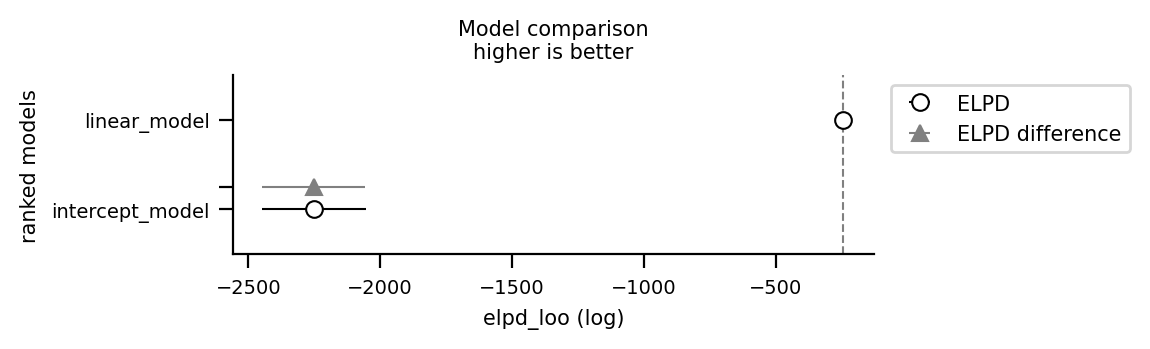

In [12]:
az.plot_compare(df_comp_loo, insample_dev=False);

## Commenti e considerazioni finali 

Il capitolo ha illustrato l'importanza e l'applicabilità dell'Expected Log Predictive Density (elpd) nel contesto della modellazione statistica. Questa misura emerge come uno strumento cruciale, non solo per l'analisi delle proprietà di un singolo modello ma anche per il confronto tra modelli diversi.

L'utilizzo dell'elpd come metrica di confronto offre una prospettiva oggettiva, permettendo di determinare con precisione quale modello si adatta meglio ai dati osservati. In un panorama sempre più complesso, dove spesso si presentano molteplici alternative di modellazione, l'elpd diventa un alleato prezioso nella selezione del modello più appropriato. Che si tratti di valutare l'efficacia di un modello più complesso rispetto a uno più semplice o di scegliere tra varianti sostanzialmente differenti, l'elpd fornisce una guida solida e basata sui dati.

In sintesi, il calcolo e l'interpretazione dell'elpd rivestono un ruolo centrale nella moderna analisi dei dati. La sua applicazione può ridurre l'ambiguità nelle scelte di modellazione, conducendo a conclusioni più robuste e a modelli più efficaci. 